In [ ]:
import os
import random
import numpy as np
from glob import glob
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from torchvision.models import inception_v3
from data_processing import make_dataloader
from utils import compute_activation_statistics, load_or_compute_real_stats
from utils import compute_fid_score_unified
from gan import DCGANGenerator, DCGANDiscriminator, train_dcgan,train_lsgan, interpolate_and_generate
from vae import VAE, train_vae, generate_vae_samples, vae_interpolate
import matplotlib.pyplot as plt
import torchvision.utils as vutils
class CatsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = glob(os.path.join(root_dir, '*.jpg'))
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        # Return a dummy label (0) since we don't have classes
        return image, 0

def make_dataloader(cfg):
    transform = transforms.Compose([
        transforms.Resize((cfg.image_size, cfg.image_size)),
        transforms.CenterCrop(cfg.image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    ds = CatsDataset(cfg.root_path, transform=transform)
    loader = DataLoader(ds, batch_size=cfg.batch_size, shuffle=True, num_workers=4)
    return loader

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False    
set_seed(42)
class Config:
    # Data
    root_path = 'train'             # path to cats-only images
    image_size = 64                     # resize all images to this size
    batch_size = 64
    ndf = 64                     # number of discriminator filters
    ngf = 64                     # number of generator filters

    # Model & training
    latent_dim = 100
    lr = 0.0001
    beta1 = 0.5                         # for Adam
    num_epochs = 30

    # FID
    fid_batch = 50
    device = "cuda"

cfg = Config()


loader_cats_dogs = make_dataloader(cfg)

In [8]:
gen_cats_dogs, disc_cats_dogs, history = train_lsgan(loader_cats_dogs, cfg, save_path=f'./histories/wgan_30_epochs.pkl')

[LSGAN] Epoch 1/30 - Loss D: 0.1912, Loss G: 1.0823
[LSGAN] Epoch 2/30 - Loss D: 0.0681, Loss G: 0.4016
[LSGAN] Epoch 3/30 - Loss D: 0.0667, Loss G: 0.4251
[LSGAN] Epoch 4/30 - Loss D: 0.0868, Loss G: 0.3991
[LSGAN] Epoch 5/30 - Loss D: 0.0881, Loss G: 0.4199
[LSGAN] Epoch 6/30 - Loss D: 0.1106, Loss G: 0.3964
[LSGAN] Epoch 7/30 - Loss D: 0.1036, Loss G: 0.4098
[LSGAN] Epoch 8/30 - Loss D: 0.0831, Loss G: 0.4243
[LSGAN] Epoch 9/30 - Loss D: 0.0833, Loss G: 0.4210
[LSGAN] Epoch 10/30 - Loss D: 0.0853, Loss G: 0.4023
[LSGAN] Epoch 11/30 - Loss D: 0.0820, Loss G: 0.3922
[LSGAN] Epoch 12/30 - Loss D: 0.0844, Loss G: 0.3913
[LSGAN] Epoch 13/30 - Loss D: 0.0741, Loss G: 0.3954
[LSGAN] Epoch 14/30 - Loss D: 0.0760, Loss G: 0.3913
[LSGAN] Epoch 15/30 - Loss D: 0.0729, Loss G: 0.3930
[LSGAN] Epoch 16/30 - Loss D: 0.0724, Loss G: 0.3956
[LSGAN] Epoch 17/30 - Loss D: 0.0671, Loss G: 0.3873
[LSGAN] Epoch 18/30 - Loss D: 0.0679, Loss G: 0.3894
[LSGAN] Epoch 19/30 - Loss D: 0.0668, Loss G: 0.3903
[L

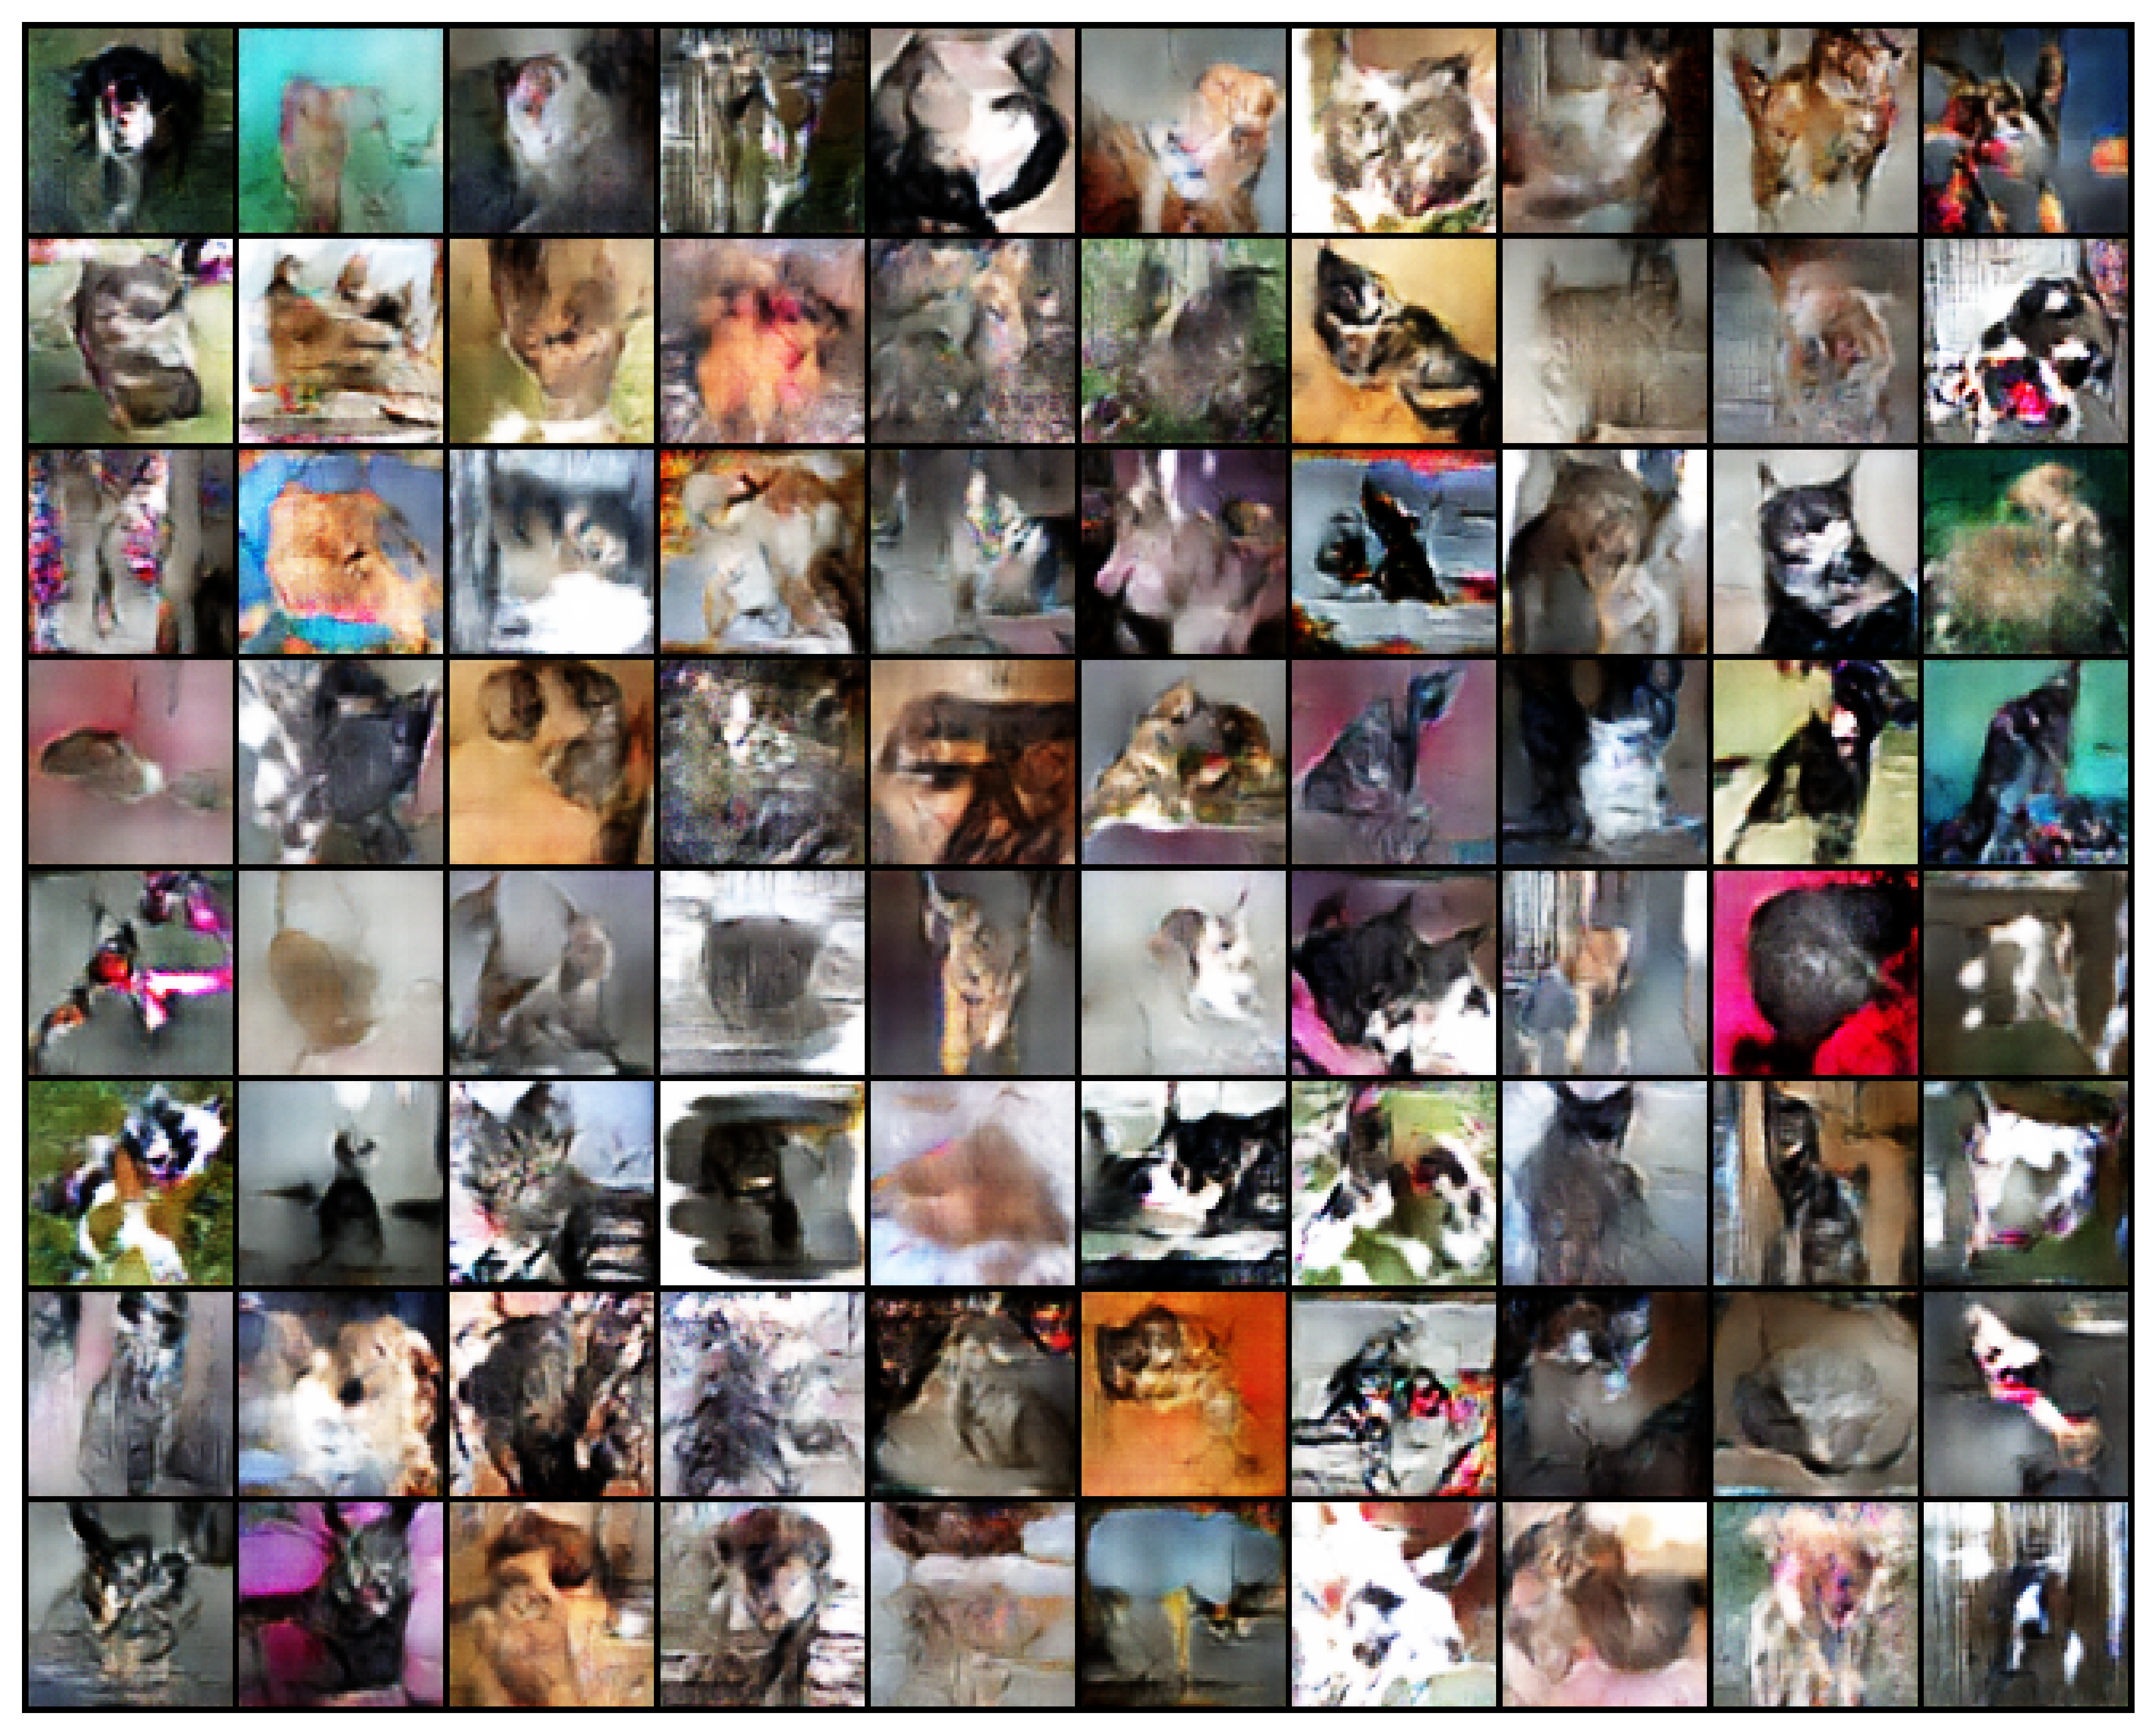

In [16]:
z = torch.Tensor([np.random.randn(cfg.latent_dim, 1, 1) for _ in range(80)]).to("cuda")
imgs = gen_cats_dogs(z)
grid = vutils.make_grid(imgs, nrow=10, normalize=True)

# Convert to numpy and permute to (H, W, C)
npimg = grid.cpu().numpy().transpose(1, 2, 0)

# Display the image
plt.figure(figsize=(15, 10),dpi=400)  # adjust figsize as needed
plt.imshow(npimg)
plt.axis('off')
plt.savefig('catdogs')
plt.show()